# Natual Language Practice with PDFs: Clustering and Topic Modeling KDD 2015 Submitted Research Papers

This notebook highlights my self-motivated journey to practice natural language processing pipelines on real data sets.  I attended KDD 2015 (http://www.kdd.org/kdd2015/) and wanted to topic model and cluster KDD 2015's research papers.  My classroom training in natural language processing is extremlely limited.  Most of my base training occured via self-study and in Georgetown University's Data Science certificate program; that gave me the foundation and baseline understanding needed to take on this task.  With that said, there may be some inefficiencies in the code (you may know a way to do it better; please add).  My first goal is to figure out how to perform a task in a programmatic way (i.e. extract text from pdf).  Next, I hope to turn these little code blocks into functions.  And finally, maybe I'll create some type of classes or module that can be used to extract data from research papers and topic model with a few lines of code.  For now, this is a coding journal of sorts.

Acknowledgements:  The vast majority of the code AFTER the proprocessing code block is from http://brandonrose.org/clustering.  Brandon used movie synopses and had a file already processed as you can see from the code.  In my case, I had pdfs so added a few pieces that would give extra information. I added the piece on extracting entities from the section of the paper that lists authors and universities.  I used the Stanford and NLTK entity extractors  which can be found at  http://nlp.stanford.edu/software/CRF-NER.shtml and http://www.nltk.org/api/nltk.chunk.html. A future task is to compare the extracted entities to see which universities or people work on which topic.  

In [10]:
from os import walk
import os
import pandas as pd
import subprocess
import sys
import nltk
import time
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import time
import json
import re
import urllib2
import unicodedata
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize
import time
from tqdm import *

wordnet_tags = ['n', 'v', 'a', 's', 'r']
%matplotlib inline


# The main code, built from testing, is in the cell immediately below. 

In [27]:
###  This is just some code to import needed libraries for processing and a function copied from the link below

In [8]:
# from http://brandonrose.org/clustering



from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()
wordnet_tags = ['n', 'v', 'a', 's', 'r']

def tokenize_and_stem_n_lem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    
    stems = [stemmer.stem(lemmer.lemmatize(l)) for l in filtered_tokens]
    
    #return stems,lems
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

### This code block prepreocesses the directory of KDD 2015 PDF files and turns it into a dict; I start with 83 files

Janitorial work is often the most time consuming.  I'm new, and this code took me quite a bit of time (spread out over weeks of spare time) tinkering with the pdf file output to get exactly what I wanted.  The goal was to extract the text from the pdf file and identify things like titles, abstract, entities, etc.  I was never able to figure out a way to get the body only (because it came right at the end) but I will revisit that.  The next goal is to write this section into a function.  

In [12]:


path        = os.path.abspath(os.getcwd())
TESTDIR     = os.path.normpath(os.path.join(os.path.expanduser("~"),"projects","LC3-Creations", "examples","KDDsample"))

corpus = {}
%time
start_time = time.time()
for dirName, subdirList, fileList in tqdm(walk(TESTDIR)):    
    for fileName in fileList:
        if fileName.startswith('p') and fileName.endswith('.pdf'):
            a = unicode(subprocess.check_output(['pdf2txt.py',str(os.path.normpath(os.path.join(TESTDIR,fileName)))]),errors='ignore')
            document = unicodedata.normalize('NFKD', a).encode('ascii','ignore')

            if len(document)<300:
                pass
            else:

                # The entire document
                body = re.sub('[\s]'," ",document)

                # Getting title
                title = re.findall("^[^\\n\\n]+",document)[0]

                # Getting the abstract
                try:
                    abstract = re.findall (r'(Abstract|ABSTRACT)([^]]*)\n',document[:2000])
                except IndexError:
                    abstract = re.findall (r'(Abstract|ABSTRACT)([^]]*)\n',document[:2000])[0]
                else:
                    abstract = abstract = re.findall (r'(Abstract|ABSTRACT)([^]]*)\n',document[:2000])[0][1]

                if isinstance(abstract, tuple):
                    abstract = re.sub('[\s]'," ",abstract[1])
                elif isinstance(abstract,list):
                    abstract = re.sub('[\s]'," ",abstract[1])
                elif isinstance(abstract,str):
                    abstract = re.sub('[\s]'," ", abstract)


                # Extracts section with names and email addresses only
                section  = re.findall (r'\n\n([^]]*)\n\n(Abstract|ABSTRACT)',document[:2000])

                type(section[0][0])

                if isinstance(section, list):
                    section = re.sub('[\s]'," ",section[0][0])
                else:
                    section = re.sub('[\s]'," ",section)


                # Code to extract entities from top section of pdf and store a relationship tree
                tagged = nltk.pos_tag(nltk.word_tokenize(section))
                entities = nltk.chunk.ne_chunk(tagged)

                # Another entity extractor
                st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.conll.4class.distsim.crf.ser.gz',
                       '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-corenlp-3.5.2.jar',
                       encoding='utf-8')
                tokenized_text = word_tokenize(section)
                stanentities = st.tag(tokenized_text)

                # Calls function to lemmatize and stem the document; stores the result
                tokenize_and_stem_n_lem(abstract);


                # Creates the json document format to store the files
                corpus[str(fileName)]={}
                corpus[str(fileName)]={'Title':title,'body':body,'Abstract':abstract,'Entities':entities, 
                                       "Stanford ER":stanentities, "Stems": tokenize_and_stem_n_lem(abstract)}
    time.sleep(.01)


1it [14:50,  0.00it/s]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


CalledProcessError: Command '['pdf2txt.py', '/Users/linwood/projects/LC3-Creations/examples/KDDsample/p1.pdf']' returned non-zero exit status 1

### Tokenizing the Corpus:  Creating lists for later processing

I likely am wasting a lot of in memory resources here.  I created a nested dict in the preprocessing code block above.  But, in order to use the example I found on line, I needed lists of those extracted pieces of data (i.e abstracts or titles).  I could likely iterate over the nested dict values and just store that directly into my desired result but I added an extra step to iterate over the nested dict, create a list, and then iterate over that created list.  Not very efficient I know, but as stated, I'm a beginner.  Knowing I can somehow make this more efficient is a good step in my opinion.  In thinking about it, I can likely use a "list.extend()" line by just iterating of the nested dicts values and added them to my target list.  Monday morning quarterback.

In [13]:
# Creating lists for abstracts, titles, and entities for later processing
# The lists are probably wasteful; I created a nested dict with all these files in corpus; I'm learning along the way

abstracts = [i['Abstract'] for i in corpus.values()[:]]
titles = [i['Title'] for i in corpus.values()[:]]
ents = [i['Entities'] for i in corpus.values()[:]]
bodies = [i['body'] for i in corpus.values()[:]]


totalvocab_stemmed = []
totalvocab_tokenized = []
for i in bodies:
    allwords_stemmed = tokenize_and_stem_n_lem(i) #for some reason, had to add index in list here
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

### Creating a pandas dataframe for original token lookup

The title says it all; this is from the web page http://brandonrose.org/clustering.  Just a cut and paste job.  

In [28]:
# Build a pandas dataframe to match tokenized stems to the original word from the text

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
vocab_frame.head()

there are 696408 items in vocab_frame


,words
local,locally
densest,densest
subgraph,subgraph
discoveri,discovery
lu,lu


###  Estimating Document Similarity using scikit-learn's TF-IDF module

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.6, max_features=200000,
                                 min_df=0.3, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem_n_lem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(bodies) #fit the vectorizer to synopses

print(tfidf_matrix.shape)
print()
print()
terms = tfidf_vectorizer.get_feature_names()
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print (dist)
print()
print()

CPU times: user 39 s, sys: 852 ms, total: 39.9 s
Wall time: 39.7 s
(83, 674)
()
()
[[  0.00000000e+00   8.64703292e-01   8.73062181e-01 ...,   9.84277109e-01
    8.25760139e-01   8.34428444e-01]
 [  8.64703292e-01   0.00000000e+00   8.88281985e-01 ...,   8.50298853e-01
    7.44062665e-01   6.98094729e-01]
 [  8.73062181e-01   8.88281985e-01   0.00000000e+00 ...,   8.35326543e-01
    9.05971569e-01   8.00989157e-01]
 ..., 
 [  9.84277109e-01   8.50298853e-01   8.35326543e-01 ...,  -2.22044605e-16
    9.27796913e-01   8.16029283e-01]
 [  8.25760139e-01   7.44062665e-01   9.05971569e-01 ...,   9.27796913e-01
    0.00000000e+00   7.27143676e-01]
 [  8.34428444e-01   6.98094729e-01   8.00989157e-01 ...,   8.16029283e-01
    7.27143676e-01  -2.22044605e-16]]
()
()


###  Use scikit-learn's KMeans clustering to cluster the documents into 5 topic areas/categories

In [22]:
from sklearn.cluster import KMeans
import numpy as np

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)


print (len(km.labels_.tolist()))
kdd2015 = { 'title': titles, 'abstract': abstracts}
frame = pd.DataFrame(kdd2015, columns = ['title', 'abstract'])
frame['cluster'] = np.asarray(km.labels_.tolist())
frame.head()

CPU times: user 99.9 ms, sys: 2.2 ms, total: 102 ms
Wall time: 102 ms
83


,title,abstract,cluster
0,Locally Densest Subgraph Discovery,Mining dense subgraphs from a large graph is ...,1
1,Collective Opinion Spam Detection:,Online reviews capture the testimonials of re...,1
2,Deep Computational Phenotyping,We apply deep learning to the problem of disc...,0
3,Reducing the Unlabeled Sample Complexity of,"In semi-supervised multi-view learning, unlab...",2
4,Non-transitive Hashing with Latent Similarity ...,Approximating the semantic similarity between...,4


###  With a pandas dataframe created with clusters added, you can perform SQL-like queries to explore

In [24]:
# The number of documents that are assigned to each cluster

print frame.groupby('cluster').abstract.count()
print ()
print ()

cluster
0     8
1    19
2    14
3    14
4    28
Name: abstract, dtype: int64
()
()


###  This code block prints out the words that occur most in each cluster

In [25]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :15]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title']:
        print ('%s' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: events, temporal, kernel, activities, training, neural, document, regular, cid:48, domains, inference, days, carefully, series, date,

Cluster 0 titles:Locally Densest Subgraph Discovery

Cluster 1 words: nodes, edges, inuence, cid:0, count, social, strategies, degree, communities, users, convex, eq, located, lemmas, density,

Cluster 1 titles:Collective Opinion Spam Detection:

Cluster 2 words: q, cid:48, queries, z, cid:13, training, density, trees, cid:17, sequences, index, mentioning, hypothesis, transform, domains,

Cluster 2 titles:Deep Computational Phenotyping

Cluster 3 words: topics, users, source, communities, activities, dynamic, located, item, latent, rank, cid:13, document, regions, recommended, eq,

Cluster 3 titles:Reducing the Unlabeled Sample Complexity of

Cluster 4 words: kernel, block, xi, classier, image, i=1, rank, records, classes, dimensionality, training, attributed, document, matches, relationship,

Cluster 4 titles:No

###  Mutlidimensional scaling to project our results into a two dimensional graphic 

In [29]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

###  Creating colors to represent our clusters and cutting a pasting words from above to represent titles of clusters

In [35]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'events, temporal, kernel, neural', 
                 1: 'nodes, edges, social, communities', 
                 2: 'queries,training, density, trees', 
                 3: 'topics, users, latent, rank, recommended', 
                 4: 'kernel, image, classes, dimensionality, relationship'}

###  Visualize the documents and their titles in space with colors

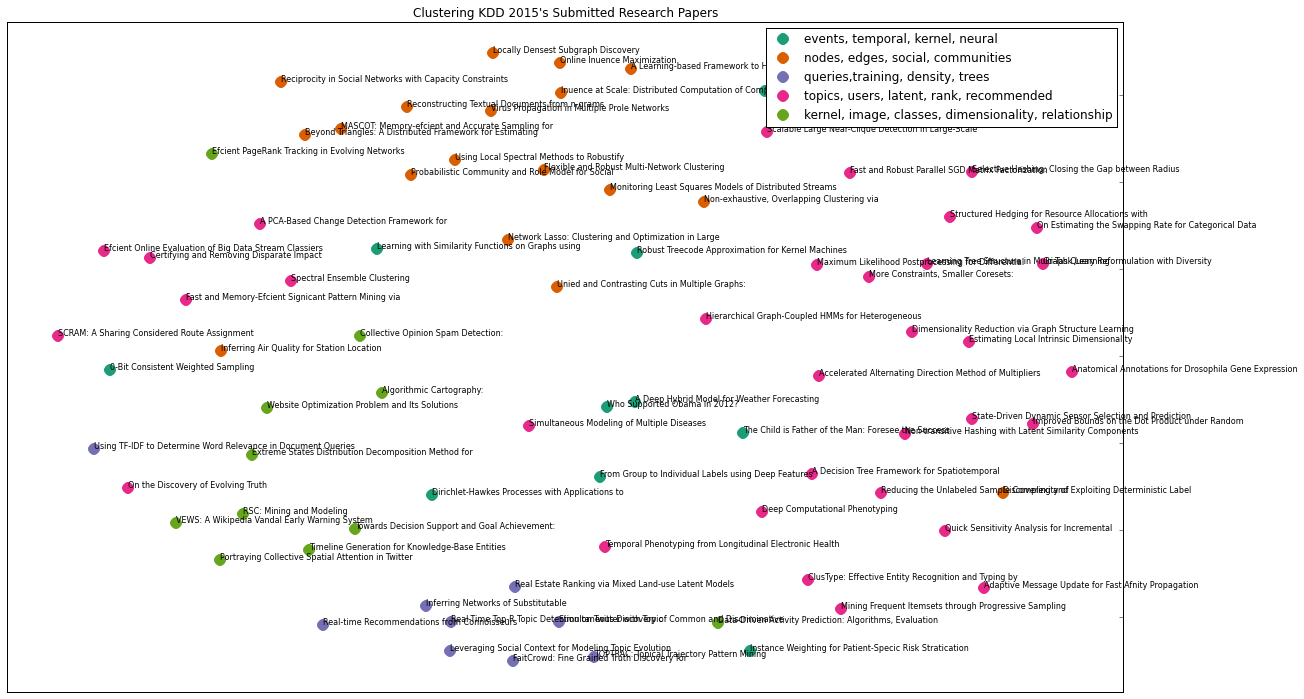

In [36]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 8)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
plt.title("Clustering KDD 2015's Submitted Research Papers")    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

### Using mpld3 to clean up the visualization and make it interacitve

In [37]:
import mpld3
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

###  The visualization using mpld3

In [38]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,13)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

###  The obligatory dendrogram

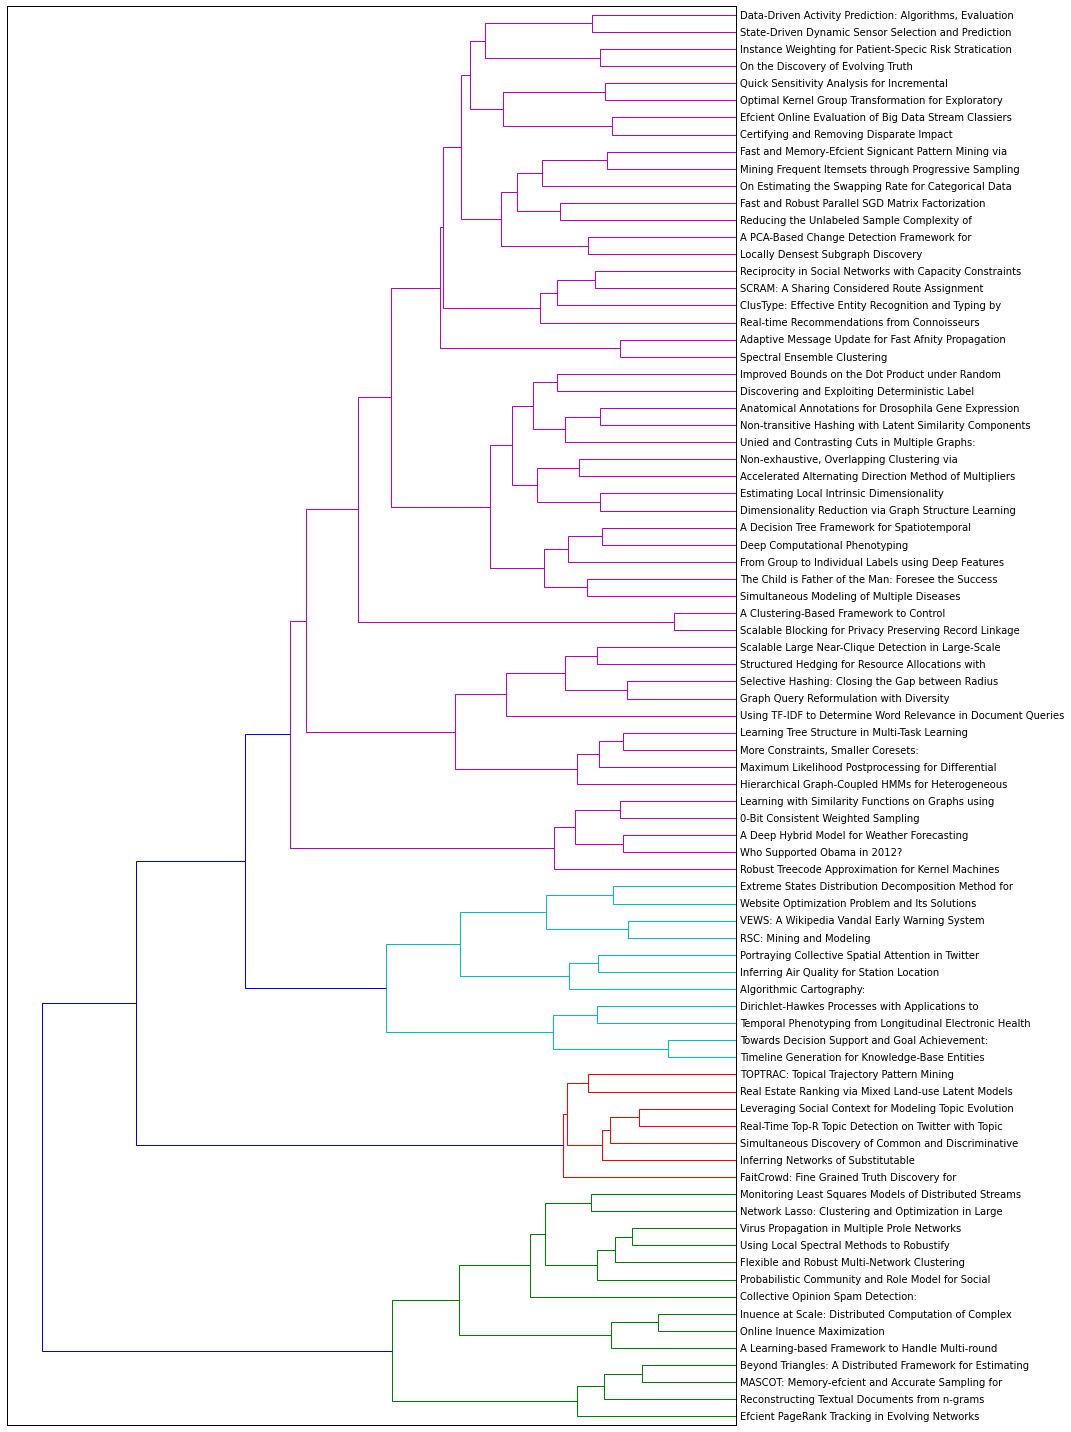

In [39]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

# Placeholder to see the struture of the preprocessed file we will use for input

In [26]:
# Remove the semicolon to see the output
corpus.keys();

# Testing/building individual components happens below; then I paste it above

In [40]:
# Iterate over a specific embedded key in an nested dict
[i['Abstract'] for i in corpus.values()[:]];

In [ ]:
# Convert document from unicode to string 

import unicodedata
document = unicodedata.normalize('NFKD', a).encode('ascii','ignore')
document[:2500]

In [ ]:
# Getting title
title = re.findall("^[^\\n\\n]+",document)[0]
title

# Getting the abstract
abstract = re.findall (r'\n\n(Abstract|ABSTRACT)([^]]*)\n\n',document[:2000])[0]

if isinstance(abstract, tuple):
    abstract = re.sub('[\s]'," ",abstract[1])
else:
    abstract = re.sub('[\s]'," ",abstract)
abstract

In [ ]:
# Extracts section with names and email addresses only

section  = re.findall (r'\n\n([^]]*)\n\n(Abstract|ABSTRACT)',document[:2000])

type(section[0][0])

if isinstance(section, list):
    section = re.sub('[\s]'," ",section[0][0])
else:
    section = re.sub('[\s]'," ",section)
section


In [ ]:
# Code to extract entities from top section of pdf and store a relationship tree

import nltk

tagged = nltk.pos_tag(nltk.word_tokenize(section))
entities = nltk.chunk.ne_chunk(tagged)
entities.collapse_unary

In [ ]:
# Use another entity extractor


from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.conll.4class.distsim.crf.ser.gz',
					   '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-corenlp-3.5.2.jar',
					   encoding='utf-8')

text = section
tokenized_text = word_tokenize(section)
classified_text = st.tag(tokenized_text)

print(classified_text)

In [ ]:
# Creates the json document format to store the files

corpus = {}
corpus[str(fileName)]={}
corpus[str(fileName)]={'Title':title,'Abstract':abstract,'Entities':entities}
corpus['p99.pdf']={'Title':"Test title",'Abstract':"test abstract langauge.  Just adding test to make it longer", 'Entities':"Linwood Creekmore"}

corpus.keys()

corpus

In [ ]:
# Testing how to use the Stanford NER Tagger

from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.muc.7class.distsim.crf.ser.gz',
					   '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-ner-3.5.2.jar',
					   encoding='utf-8')

st.tag(word_tokenize(section));

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
print vectorizer.fit_transform(bodies).todense()

SyntaxError: invalid syntax (<ipython-input-25-acd10adbdb67>, line 6)

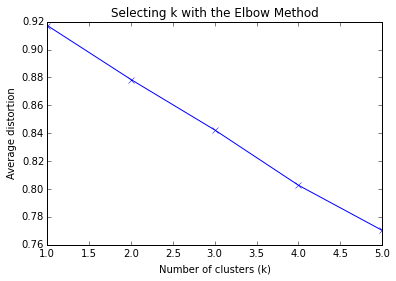

In [38]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

K = range(1,6)
meandisortions = []

for k in K:
	kmeans = KMeans(n_clusters = k)
	kmeans.fit(tfidf_matrix.todense())
	meandisortions.append(sum(np.min(cdist(tfidf_matrix.todense(),kmeans.cluster_centers_,'euclidean'),axis=1))/tfidf_matrix.todense().shape[0])

plt.plot(K,meandisortions,'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')
plt.show()

In [39]:
tfidf_matrix.todense()

matrix([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.19700216,  0.00964334],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.00339734,  0.00631945],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.00487551, ...,  0.01256415,
          0.        ,  0.00418805],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.01451274]])

In [61]:
plt.close()